In [1]:
import os
#os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
import warnings
import numpy as np
from numpy import quantile, where, random
import pandas as pd

#EDA Tools 
from pandas_profiling import ProfileReport
#import dtale

import copy 
import scipy as sp
import scipy.stats as stats
from scipy.stats import chi2
from sklearn.covariance import MinCovDet

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm


from math import ceil
import matplotlib.cm as cm

#sklearn Libraries
# For UMAP
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import (Normalizer,
                                   MinMaxScaler,
                                   RobustScaler,
                                   StandardScaler,
                                   QuantileTransformer,
                                   FunctionTransformer,
                                   PowerTransformer)



from sklearn.ensemble import IsolationForest
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.covariance import MinCovDet
from sklearn.neighbors import LocalOutlierFactor
from sklearn.manifold import TSNE

from kneed import KneeLocator

#Clusters
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram
from sklearn.neighbors import KNeighborsClassifier


import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

import logging
log = logging.getLogger('matplotlib')
log.setLevel(logging.WARNING)

warnings.filterwarnings('ignore')

In [2]:
# # Functions 
# def diagnostic_plots(df, variable):
#     # function takes a dataframe (df) and
#     # the variable of interest as arguments

#     # define figure size
#     plt.figure(figsize=(16, 4))

#     # histogram
#     plt.subplot(1, 3, 1)
#     sns.distplot(df[variable], bins=30)
#     plt.title('Histogram')

#     # Q-Q plot
#     plt.subplot(1, 3, 2)
#     stats.probplot(df[variable], dist="norm", plot=plt)
#     plt.ylabel('RM quantiles')

#     # boxplot
#     plt.subplot(1, 3, 3)
#     sns.boxplot(y=df[variable],whis=3)
#     plt.title('Boxplot')

#     plt.show()
def diagnostic_plots_box(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # boxplot
    plt.subplot(1, 3, 3)
    ax = sns.boxplot(y=df[variable], orient="h", palette="Set2", whis=4)
    plt.title('Boxplot')

    plt.show()

def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30, color='g')
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    ax = sns.boxplot(y=df[variable], orient="h", palette="Set2", whis=4)
    plt.title('Boxplot')

    plt.show()
    
def outliers_check(df):
    for feature in df:
        diagnostic_plots_box(df, feature)   
    
    return diagnostic_plots
    
    
    
    
def diagnostic_check(df):
    for feature in df:
        diagnostic_plots(df, feature)   
    
    return diagnostic_plots


def cor_heatmap(cor):
    plt.figure(figsize=(15,15))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1') # 
    plt.show()  
    
def outlier_quantiles_mean(df):

    # the boundaries are the quantiles
    for variable in df.columns:
        
        lower_limit = df[variable].quantile(0.05)
        upper_limit = df[variable].quantile(0.95)
    
        df[variable]= np.where(df[variable].isnull(), df[variable],
                      np.where(df[variable] > upper_limit, df[variable].mean(),
                      np.where(df[variable] < lower_limit, df[variable].mean(), df[variable])))
        return df

def outlier_quantiles(df):

    # the boundaries are the quantiles
    for variable in df.columns:
        
        lower_limit = df[variable].quantile(0.01)
        upper_limit = df[variable].quantile(0.99)
    
        df[variable]= np.where(df[variable].isnull(), df[variable],
                      np.where(df[variable] > upper_limit, upper_limit,
                      np.where(df[variable] < lower_limit, lower_limit, df[variable])))
    return df 

def y2m(x):
    if pd.isnull(x) == True:
        return (x)
    else:
        return((2020- (int(x[0:4])))*12 - int(x[5:7]))
    
# data_1st['LASTDATE'] = data_1st['LASTDATE'].map(lambda x:y2m(x))

# data_1st['FISTDATE'] = data_1st['FISTDATE'].map(lambda x:y2m(x))


    
#Tukey's method - Outliers 
def tukeys_method(df, variable):
    #Takes two parameters: dataframe & variable of interest as string
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3-q1
    inner_fence = 1.5*iqr
    outer_fence = 4*iqr
    
    #inner fence lower and upper end
    inner_fence_le = q1-inner_fence
    inner_fence_ue = q3+inner_fence
    
    #outer fence lower and upper end
    outer_fence_le = q1-outer_fence
    outer_fence_ue = q3+outer_fence
    
    outliers_prob = []
    outliers_poss = []
    for index, x in enumerate(df[variable]):
        if x <= outer_fence_le or x >= outer_fence_ue:
            outliers_prob.append(index)
    for index, x in enumerate(df[variable]):
        if x <= inner_fence_le or x >= inner_fence_ue:
            outliers_poss.append(index)
    return outliers_prob, outliers_poss

#print(probable_outliers_tm)
#print(possible_outliers_tm)

# Function to run turkeys method to the dataframe.
def outliers_drop(df):
    liers= []
    for features in df:
        prob = tukeys_method(df, features)[0]
        liers = liers + prob
    to_drop = np.unique(liers)
    df_nout = df.drop(to_drop,axis = 0)
    return(df_nout)

#returns indexes
def outliers_index(df):
    liers= []
    for features in df:
        prob = tukeys_method(df, feature).outliers_prob
        liers = liers + prob
    to_drop = np.unique(liers)
    return(to_drop)

In [3]:
donors = pd.read_csv('donors.csv')

In [4]:
#'AGE907''LASTDATE'

In [5]:
features = donors[['RAMNTALL', 'NGIFTALL', 'FISTDATE','IC1', 'HHAS4', 'VOC2', 'LFC1', 'EC1', 'EIC9', 'HV2', 'MHUC1']]

In [6]:
neighbourhood = donors[['IC1', 'HHAS4', 'VOC2', 'LFC1', 'EC1', 'EIC9', 'HV2', 'MHUC1']]

In [7]:
neighbourhood.head()

,IC1,HHAS4,VOC2,LFC1,EC1,EIC9,HV2,MHUC1
0,307,1,77,56,120,6,635,6
1,1088,3,92,70,160,11,5218,20
2,251,11,65,65,120,3,546,9
3,386,20,43,69,120,3,1263,16
4,240,14,45,61,120,2,594,6


In [8]:
gift = donors[['RAMNTALL', 'NGIFTALL', 'FISTDATE']]

In [9]:
gift.head()

,RAMNTALL,NGIFTALL,FISTDATE
0,240.0,31,2009-11-01
1,47.0,3,2013-10-01
2,202.0,27,2010-01-01
3,109.0,16,2007-02-01
4,254.0,37,1999-03-01


In [10]:
features.head()

,RAMNTALL,NGIFTALL,FISTDATE,IC1,HHAS4,VOC2,LFC1,EC1,EIC9,HV2,MHUC1
0,240.0,31,2009-11-01,307,1,77,56,120,6,635,6
1,47.0,3,2013-10-01,1088,3,92,70,160,11,5218,20
2,202.0,27,2010-01-01,251,11,65,65,120,3,546,9
3,109.0,16,2007-02-01,386,20,43,69,120,3,1263,16
4,254.0,37,1999-03-01,240,14,45,61,120,2,594,6


In [11]:
features.isnull().sum()

RAMNTALL    0
NGIFTALL    0
FISTDATE    2
IC1         0
HHAS4       0
VOC2        0
LFC1        0
EC1         0
EIC9        0
HV2         0
MHUC1       0
dtype: int64

In [12]:
#turning dates into months. 
features['FISTDATE'] = features['FISTDATE'].map(lambda x:y2m(x))

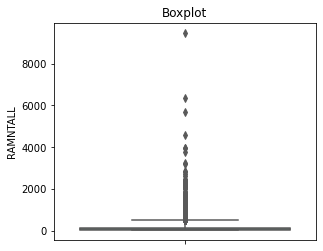

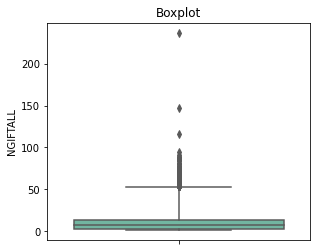

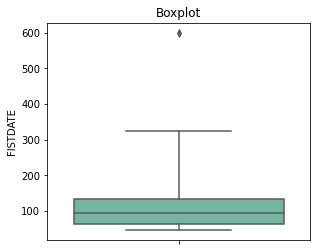

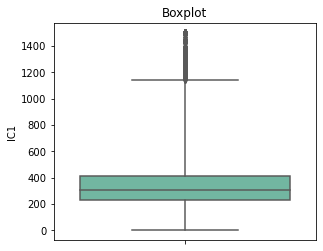

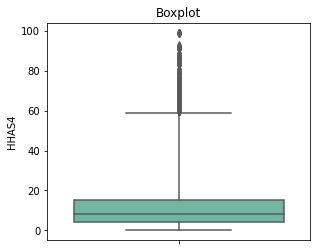

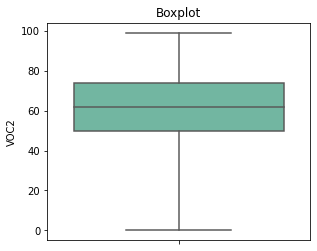

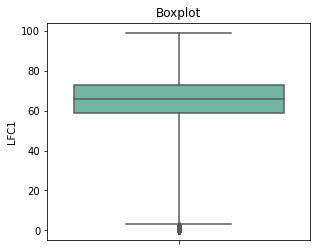

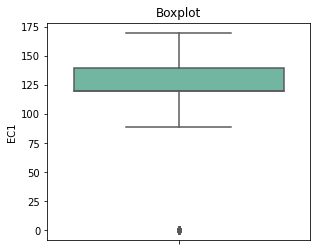

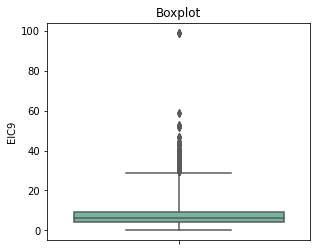

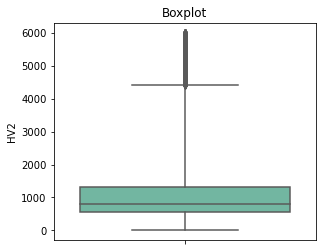

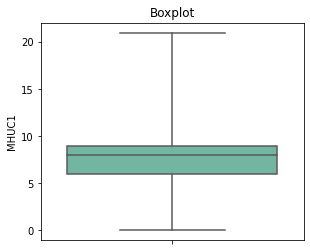

<function __main__.diagnostic_plots(df, variable)>

In [13]:
outliers_check(features)

In [14]:
# # Creating feature Age from DOB - data of birth.
# # donors_info = donors[['DOB']]
# features['YEAR'] = features['DOB'].astype(str).str[:4]
# features['YEAR'] = features['YEAR'].astype(float)
# features['AGE'] = 2020 - features['YEAR']
# features.drop(['DOB','YEAR'],axis=1,inplace=True)

In [15]:
features.columns

Index(['RAMNTALL', 'NGIFTALL', 'FISTDATE', 'IC1', 'HHAS4', 'VOC2', 'LFC1',
       'EC1', 'EIC9', 'HV2', 'MHUC1'],
      dtype='object')

# Data Exploration / Visualization

In [16]:
# A list to keep the univariate outlier index.
outlier_list = []

In [17]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95412 entries, 0 to 95411
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   RAMNTALL  95412 non-null  float64
 1   NGIFTALL  95412 non-null  int64  
 2   FISTDATE  95410 non-null  float64
 3   IC1       95412 non-null  int64  
 4   HHAS4     95412 non-null  int64  
 5   VOC2      95412 non-null  int64  
 6   LFC1      95412 non-null  int64  
 7   EC1       95412 non-null  int64  
 8   EIC9      95412 non-null  int64  
 9   HV2       95412 non-null  int64  
 10  MHUC1     95412 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 8.0 MB


In [18]:
features.head()

,RAMNTALL,NGIFTALL,FISTDATE,IC1,HHAS4,VOC2,LFC1,EC1,EIC9,HV2,MHUC1
0,240.0,31,121.0,307,1,77,56,120,6,635,6
1,47.0,3,74.0,1088,3,92,70,160,11,5218,20
2,202.0,27,119.0,251,11,65,65,120,3,546,9
3,109.0,16,154.0,386,20,43,69,120,3,1263,16
4,254.0,37,249.0,240,14,45,61,120,2,594,6


In [19]:
features.isna().sum()

RAMNTALL    0
NGIFTALL    0
FISTDATE    2
IC1         0
HHAS4       0
VOC2        0
LFC1        0
EC1         0
EIC9        0
HV2         0
MHUC1       0
dtype: int64

In [20]:
features.describe().T

,count,mean,std,min,25%,50%,75%,max
RAMNTALL,95412.0,104.489351,118.580367,13.0,40.0,78.0,131.00,9485.0
NGIFTALL,95412.0,9.602031,8.554342,1.0,3.0,7.0,13.00,237.0
FISTDATE,95410.0,98.341945,37.586774,45.0,63.0,95.0,134.00,600.0
IC1,95412.0,340.056387,162.883283,0.0,231.0,310.0,414.00,1500.0
HHAS4,95412.0,10.740903,9.967409,0.0,4.0,8.0,15.00,99.0
VOC2,95412.0,60.376640,18.802320,0.0,50.0,62.0,74.00,99.0
LFC1,95412.0,64.531600,13.601579,0.0,59.0,66.0,73.00,99.0
EC1,95412.0,128.022534,17.735576,0.0,120.0,120.0,140.00,170.0
EIC9,95412.0,6.860730,4.660567,0.0,4.0,6.0,9.00,99.0
HV2,95412.0,1133.031086,947.384618,0.0,555.0,803.0,1328.25,6000.0


In [21]:
# Find both histogram and boxplot (for different range of values)

In [22]:
cor_check = features.corr(method = "pearson") 

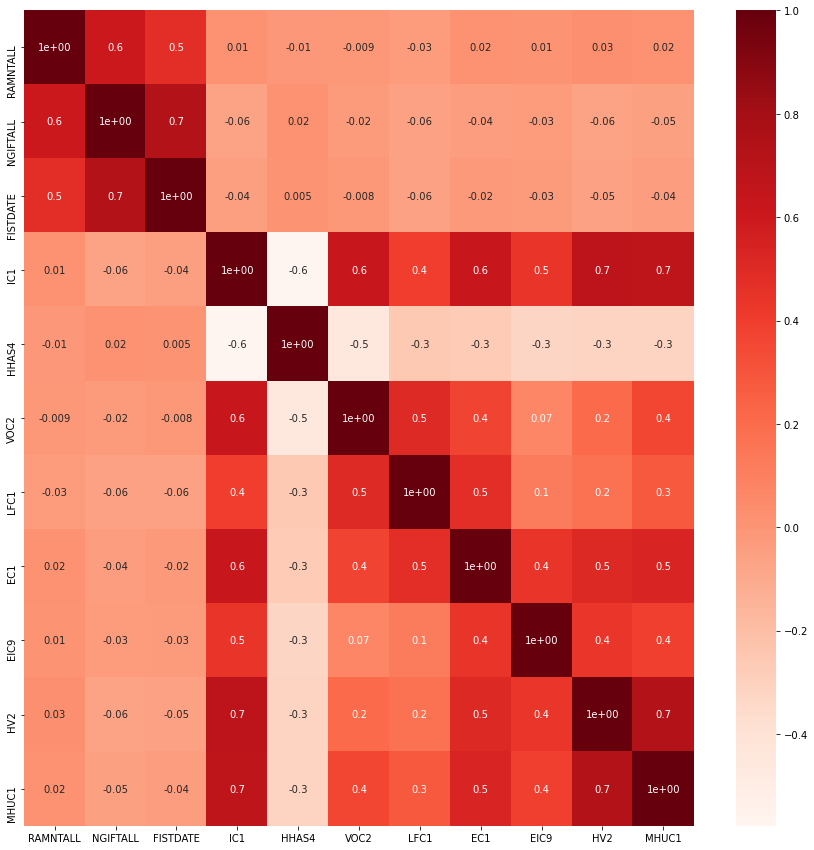

In [23]:
cor_heatmap(cor_check)

Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


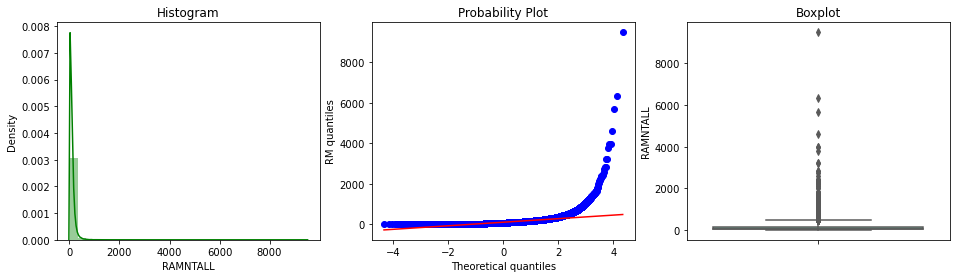

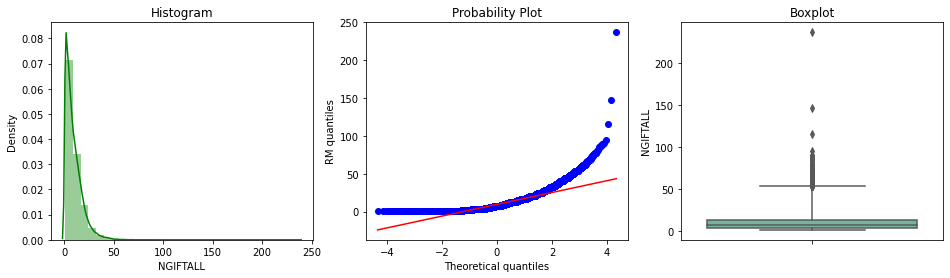

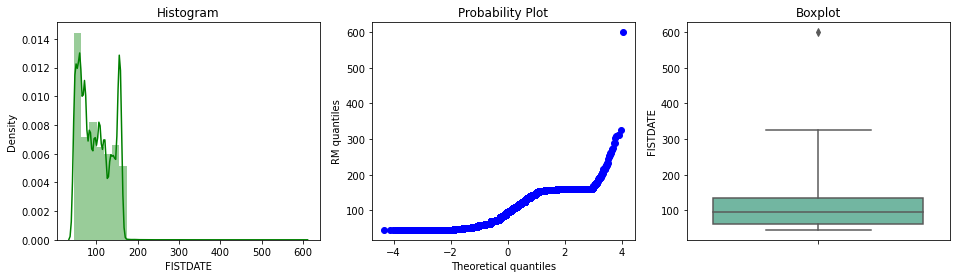

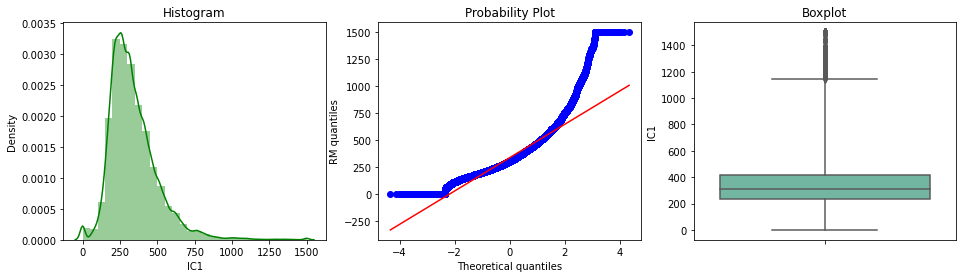

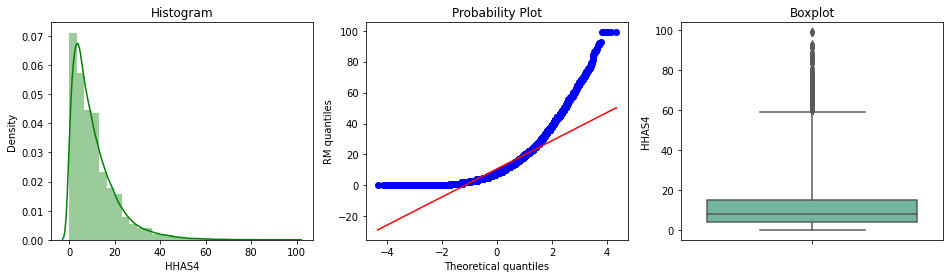

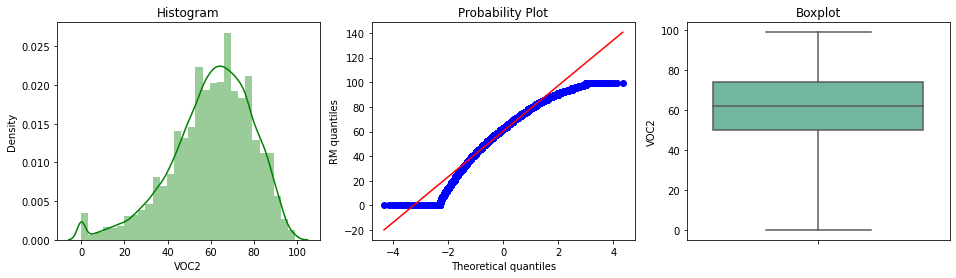

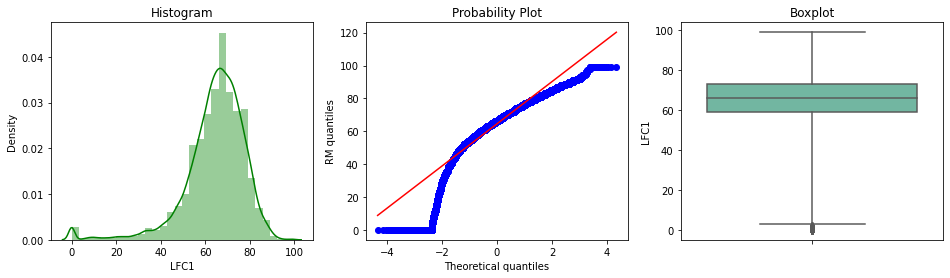

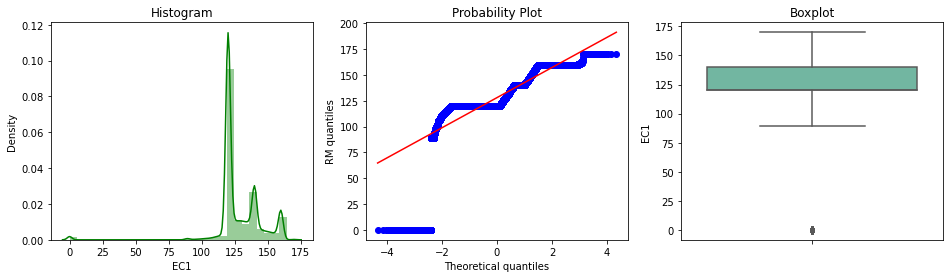

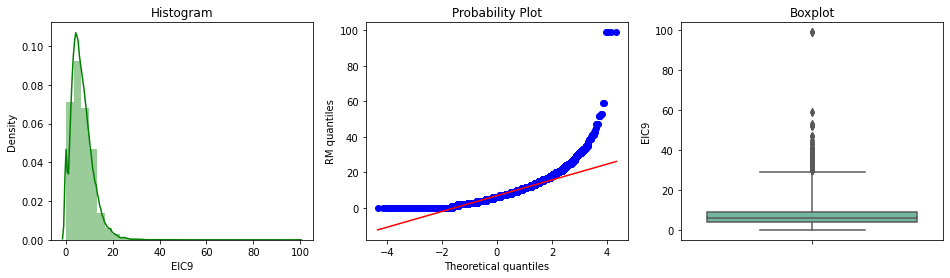

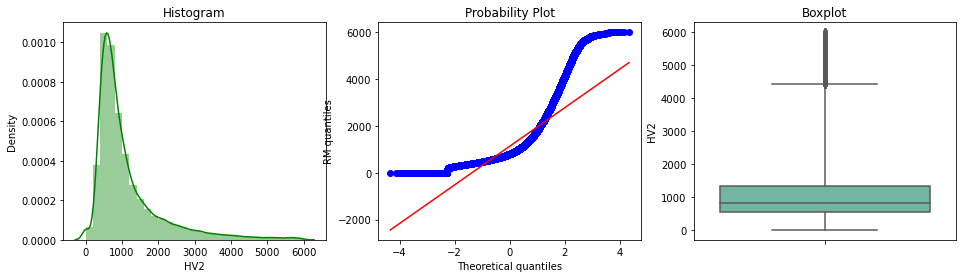

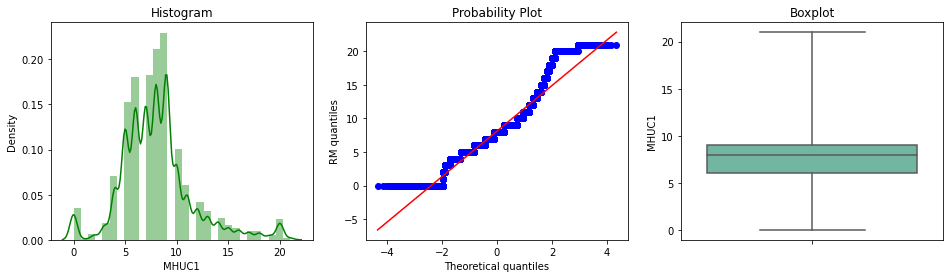

<function __main__.diagnostic_plots(df, variable)>

In [24]:
diagnostic_check(features)

- IC1 - Median Income in hundreds Household Income

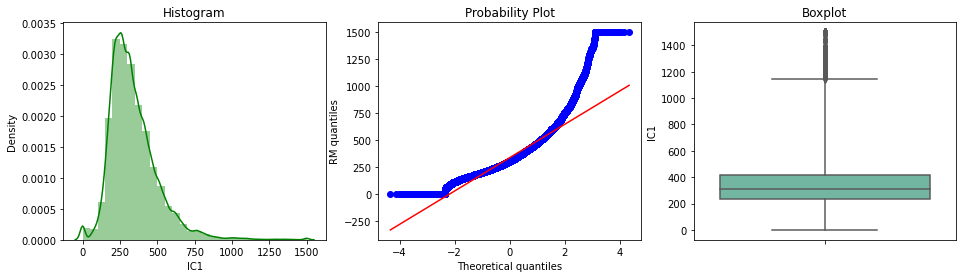

In [25]:
diagnostic_plots(features, 'IC1')

In [26]:
IC1_outliers = tukeys_method(features, 'IC1')[0]

In [27]:
len(IC1_outliers)/len(features)

0.0029031987590659456

In [28]:
outlier_list = outlier_list + IC1_outliers          

In [29]:
# len(outlier_list)

- HHAS4 Neighborhood poverty 

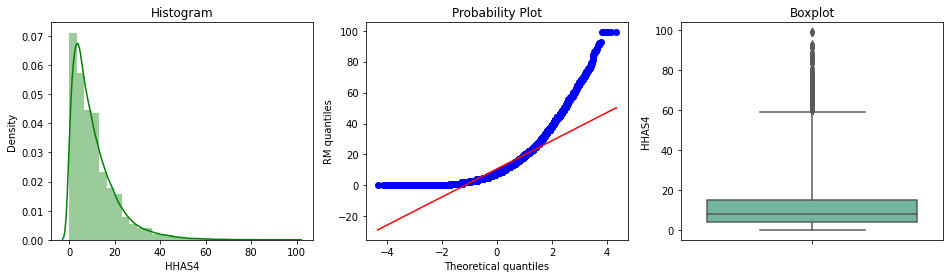

In [30]:
diagnostic_plots(features, 'HHAS4')

In [31]:
HHAS4_outliers = tukeys_method(features, 'HHAS4')[0]

In [32]:
len(HHAS4_outliers)/len(features)

0.0029975265165807234

In [33]:
outlier_list = outlier_list + HHAS4_outliers          

- VOC2

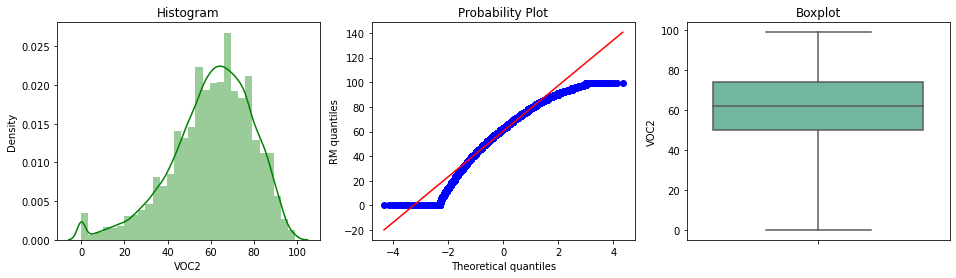

In [34]:
diagnostic_plots(features, 'VOC2')

In [35]:
VOC2_outliers = tukeys_method(features, 'VOC2')[0]

In [36]:
len(VOC2_outliers)/len(features)

0.0

In [37]:
outlier_list = outlier_list + VOC2_outliers          

- AGE907

In [38]:
# diagnostic_plots(features,'AGE907')

In [39]:
# AGE907_outliers = tukeys_method(features, 'AGE907')[0]

In [40]:
# len(AGE907_outliers)/len(features)

In [41]:
# outlier_list = outlier_list + AGE907_outliers          

- LFC1

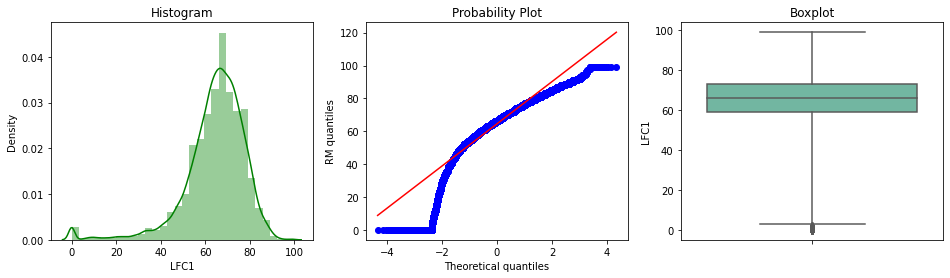

In [42]:
diagnostic_plots(features,'LFC1')

In [43]:
LFC1_outliers = tukeys_method(features, 'LFC1')[0]

In [44]:
len(LFC1_outliers)/len(features)

0.009359409717855196

In [45]:
outlier_list = outlier_list + LFC1_outliers          

- EC1

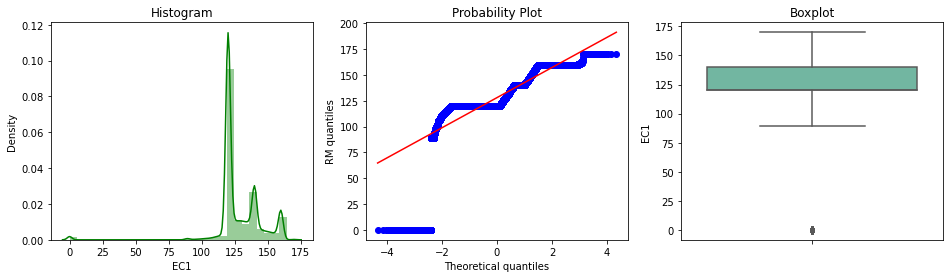

In [46]:
diagnostic_plots(features,'EC1')

In [47]:
drop_ECI_0 = list(features[features['EC1']==0].index) #drop all the zeros

In [48]:
len(drop_ECI_0)

774

In [49]:
EC1_outliers = tukeys_method(features, 'EC1')[0]

In [50]:
len(EC1_outliers)/len(features)

0.00811218714627091

In [51]:
outlier_list = outlier_list + EC1_outliers + drop_ECI_0      

- EIC9

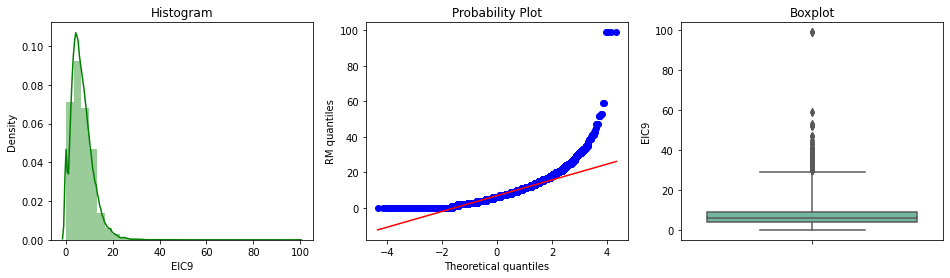

In [52]:
diagnostic_plots(features,'EIC9')

In [53]:
outliers_plus_30 = list(features[features['EIC9'] > 30].index)

In [54]:
len(outliers_plus_30)

146

In [55]:
EIC9_outliers = tukeys_method(features, 'EIC9')[0]

In [56]:
len(EIC9_outliers)/len(features)

0.0021590575608938078

In [57]:
outlier_list = outlier_list + EIC9_outliers + outliers_plus_30 

- HV2

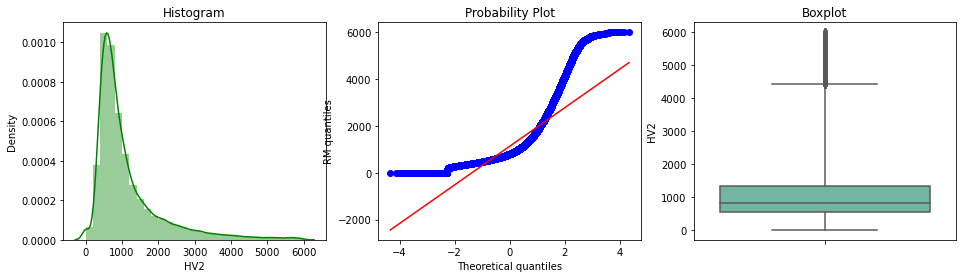

In [58]:
diagnostic_plots(features,'HV2')

In [59]:
HV2_outliers = tukeys_method(features, 'HV2')[0]

In [60]:
len(HV2_outliers)/len(features)

0.01746111600218002

In [61]:
outlier_list = outlier_list + HV2_outliers     

- MHUC1

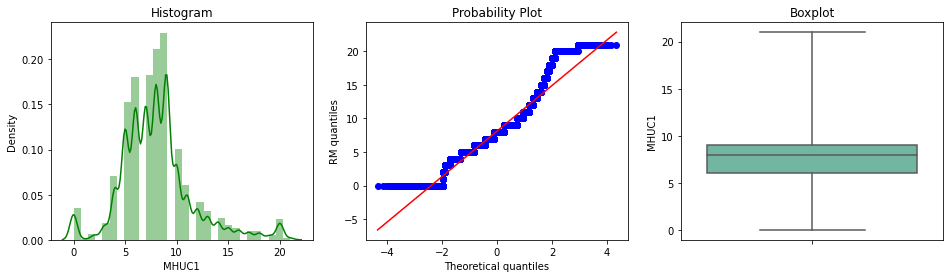

In [62]:
diagnostic_plots(features,'MHUC1')

In [63]:
MHUC1_outliers = tukeys_method(features, 'MHUC1')[0]

In [64]:
len(MHUC1_outliers)/len(features)

0.0017083804972120907

In [65]:
outlier_list = outlier_list + MHUC1_outliers     

- RAMNTALL

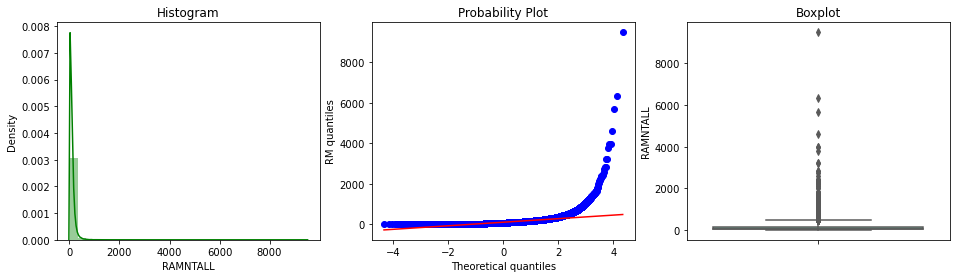

In [66]:
diagnostic_plots(features,'RAMNTALL')

In [67]:
RAMNTALL_outliers = tukeys_method(features, 'RAMNTALL')[0]

In [68]:
len(RAMNTALL_outliers)/len(features)

0.010072108330189075

In [69]:
outlier_list = outlier_list + RAMNTALL_outliers     

- NGIFTALL

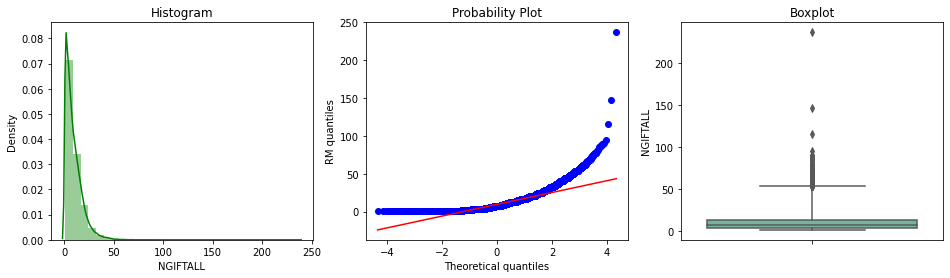

In [70]:
diagnostic_plots(features,'NGIFTALL')

In [71]:
NGIFTALL_outliers = tukeys_method(features, 'NGIFTALL')[0]

In [72]:
len(NGIFTALL_outliers)/len(features)

0.0022219427325703266

In [73]:
outlier_list = outlier_list + NGIFTALL_outliers     

- FISTDATE

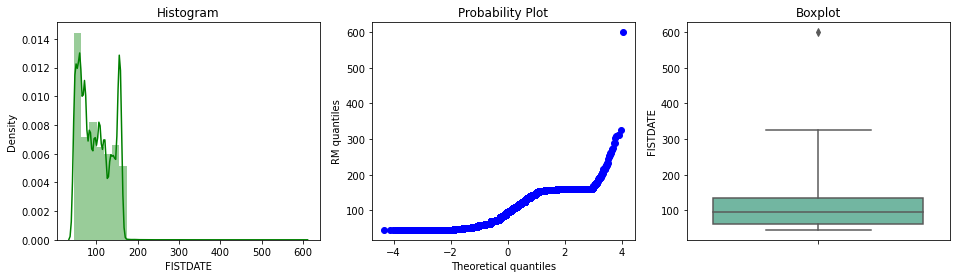

In [74]:
diagnostic_plots(features,'FISTDATE')

In [75]:
FISTDATE_outliers = tukeys_method(features, 'FISTDATE')[0]

In [76]:
out_plus_160 = list(features[features['FISTDATE'] >160].index)

In [77]:
len(features[features['FISTDATE'] >160].index)

295

In [78]:
len(FISTDATE_outliers)/len(features)

1.0480861946086445e-05

In [79]:
outlier_list = outlier_list + FISTDATE_outliers + out_plus_160

#### % of Outliers removed with univariate

In [80]:
uni_outliers_size = (len(np.unique(outlier_list))/len(features))*100
uni_outliers_size

4.602146480526558

In [81]:
drop = list(np.unique(outlier_list))

In [82]:
check_no_outliers = features.drop(drop,axis=0)

In [83]:
check_no_outliers.isnull().sum()

RAMNTALL    0
NGIFTALL    0
FISTDATE    1
IC1         0
HHAS4       0
VOC2        0
LFC1        0
EC1         0
EIC9        0
HV2         0
MHUC1       0
dtype: int64

In [84]:
# check_no_outliers.dropna(inplace=True,axis=0)

In [85]:
check_no_outliers.columns

Index(['RAMNTALL', 'NGIFTALL', 'FISTDATE', 'IC1', 'HHAS4', 'VOC2', 'LFC1',
       'EC1', 'EIC9', 'HV2', 'MHUC1'],
      dtype='object')

In [86]:
len(check_no_outliers)

91021

In [87]:
gift_check = check_no_outliers[['RAMNTALL','NGIFTALL','FISTDATE']]

In [88]:
neighborhood_check = check_no_outliers[['IC1', 'HHAS4', 'VOC2','LFC1', 'EC1', 'EIC9', 'HV2', 'MHUC1']]

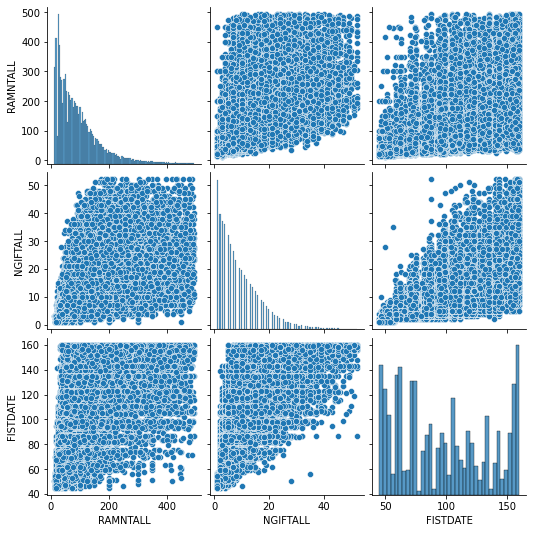

In [89]:
sns.pairplot(gift_check)

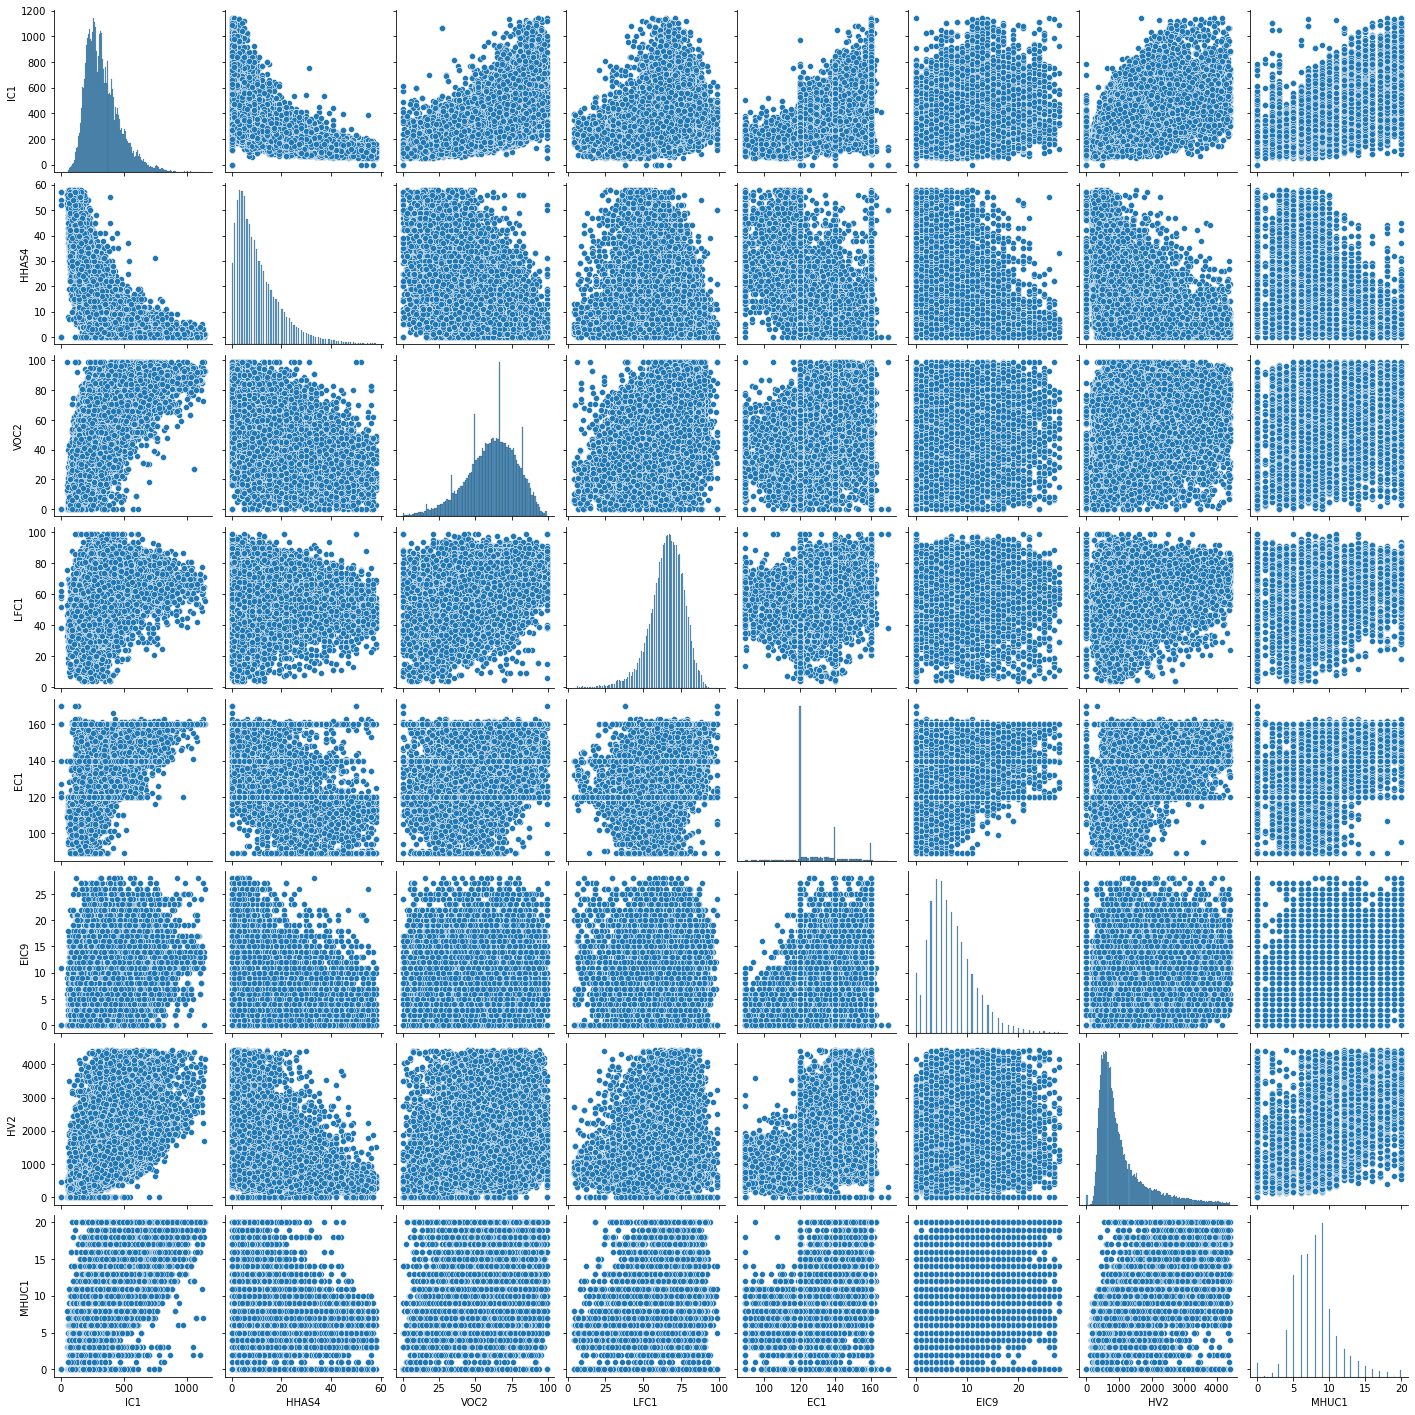

In [90]:
sns.pairplot(neighborhood_check)

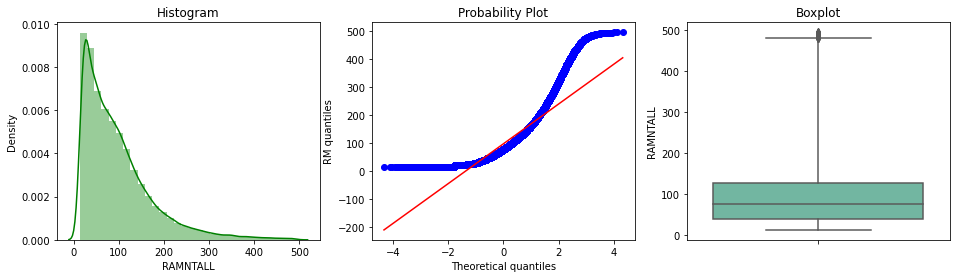

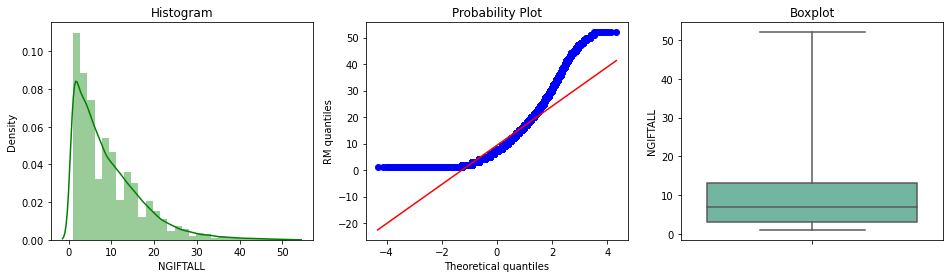

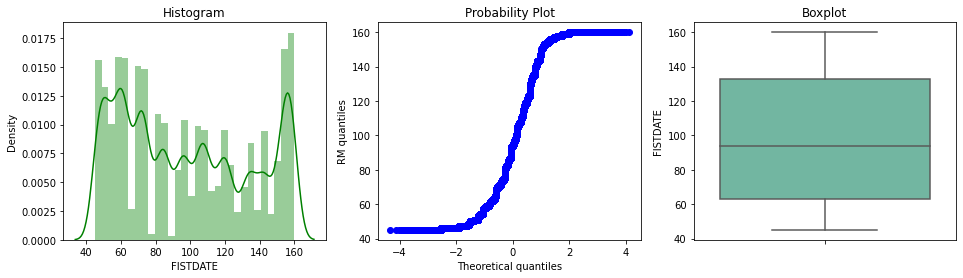

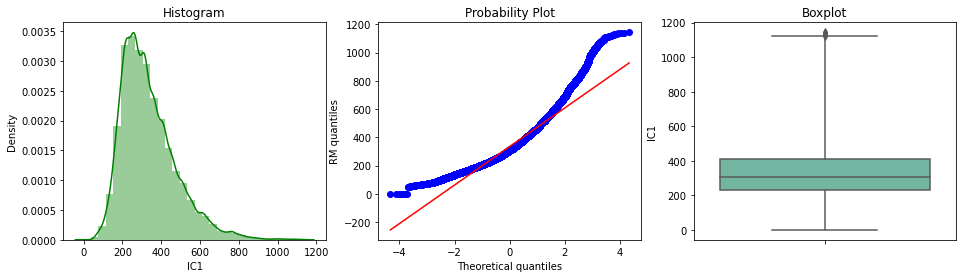

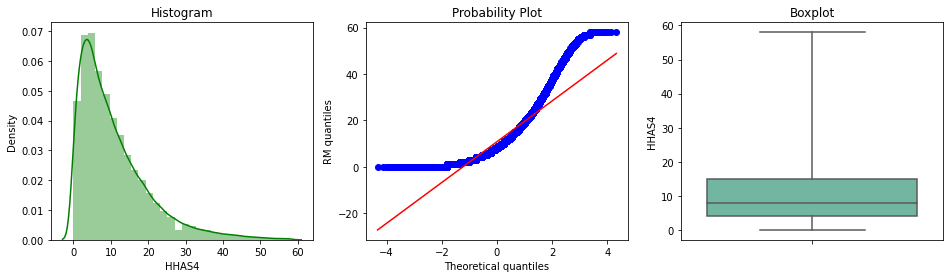

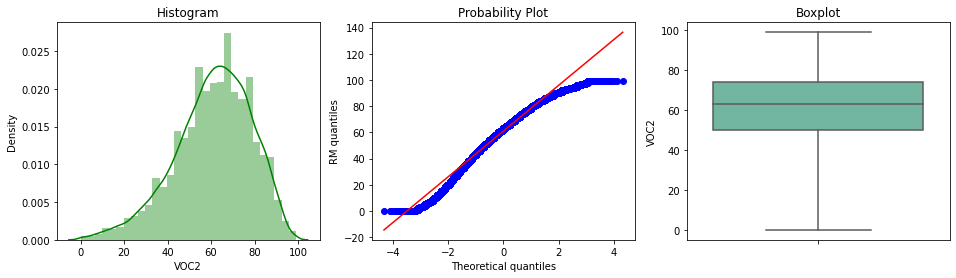

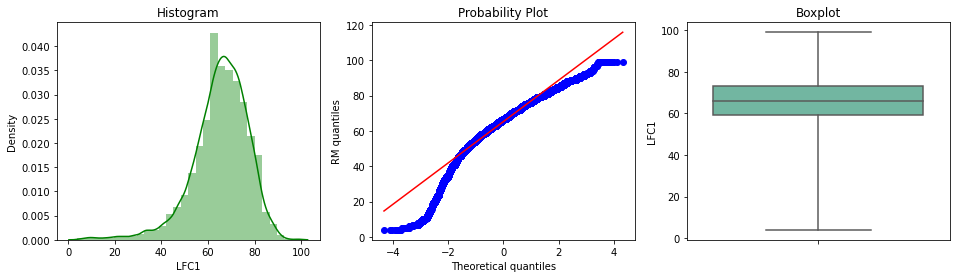

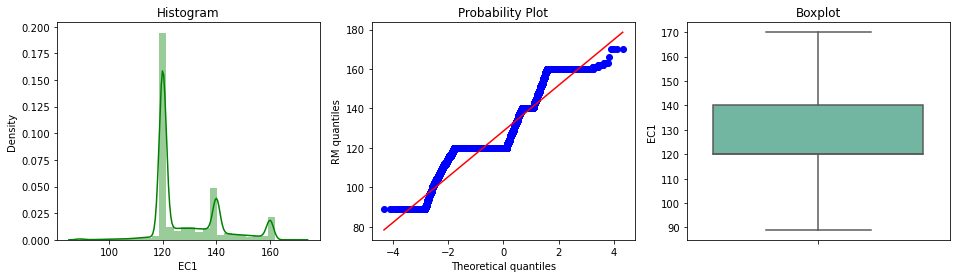

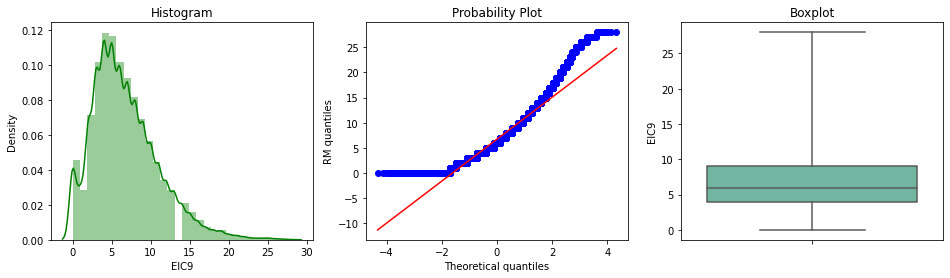

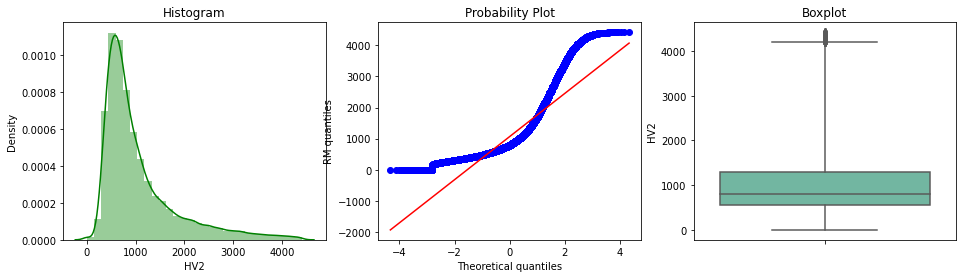

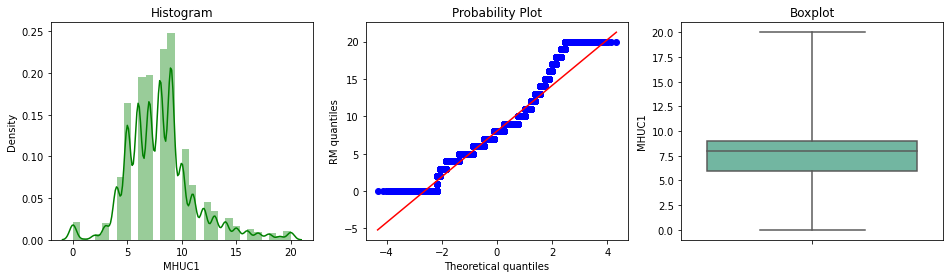

<function __main__.diagnostic_plots(df, variable)>

In [91]:
diagnostic_check(check_no_outliers)

In [92]:
check_no_outliers.isnull().sum()

RAMNTALL    0
NGIFTALL    0
FISTDATE    1
IC1         0
HHAS4       0
VOC2        0
LFC1        0
EC1         0
EIC9        0
HV2         0
MHUC1       0
dtype: int64

In [93]:
# # turning outliers to nan so we can use iterative imputer to fill them with the best values possible. 
# outlier_to_nan = pd.concat([donors_info,check_no_outliers],axis=1)

In [94]:
# outlier_to_nan.drop(['AGE'],axis=1,inplace=True)

In [95]:
# len(outlier_to_nan)

In [96]:
# outlier_to_nan.isnull().sum()

In [97]:
# diagnostic_check(outlier_to_nan)

###  Filling missing values 

In [98]:
missing_values = IterativeImputer() #sample_posterior=True #KNNImputer(n_neighbors=5, weights="uniform") # Know how  works. IterativeImputer()

In [99]:
#Filling NaN according to algorigthm. 
data = pd.DataFrame(np.round(missing_values.fit_transform(check_no_outliers)),columns=check_no_outliers.columns)

In [100]:
data.isnull().sum()

RAMNTALL    0
NGIFTALL    0
FISTDATE    0
IC1         0
HHAS4       0
VOC2        0
LFC1        0
EC1         0
EIC9        0
HV2         0
MHUC1       0
dtype: int64

In [101]:
# sns.pairplot(data)

### Outliers 

In [102]:
# outlier_removal = pd.concat([Neighborhood_cluster,Gift_cluster],axis=1)
# outlier_removal

###### Local Outlier Factor
- https://towardsdatascience.com/anomaly-detection-with-local-outlier-factor-lof-d91e41df10f2
- https://www.datatechnotes.com/2020/04/anomaly-detection-with-local-outlier-factor-in-python.html
- https://medium.com/mlpoint/local-outlier-factor-a-way-to-detect-outliers-dde335d77e1a - Hyperparameters explained
- https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/neighbors/lof.py#L200 - hyperparameters explained
- https://towardsdatascience.com/novelty-detection-with-local-outlier-factor-4867e89e4f91 - check, outlier for new data? 

In [103]:
uni_outliers_size

4.602146480526558

In [104]:
data_1st = data.copy()

In [105]:
# model specification
model1 = LocalOutlierFactor(n_neighbors = 20, metric = "manhattan",contamination = 0.03)#contamination = 0.05

In [106]:
# model fitting
y_pred = model1.fit_predict(data_1st)

In [107]:
# filter outlier index
outlier_index = where(y_pred == -1) # negative values are outliers and positives inliers

In [108]:
len(outlier_index[0])

2731

In [109]:
# filter outlier values
outlier_values = data_1st.iloc[outlier_index]

In [110]:
outliers_LOF = (len(outlier_values)/len(data_1st))*100
outliers_LOF

3.0004064995989936

In [111]:
neighb_outliers = data_1st.drop(data_1st.index[outlier_index])

In [112]:
# neighb_outliers = neighb_outliers.astype(int)

In [113]:
total_drop = uni_outliers_size  + outliers_LOF
total_drop

7.602552980125552

In [114]:
len(neighb_outliers)

88290

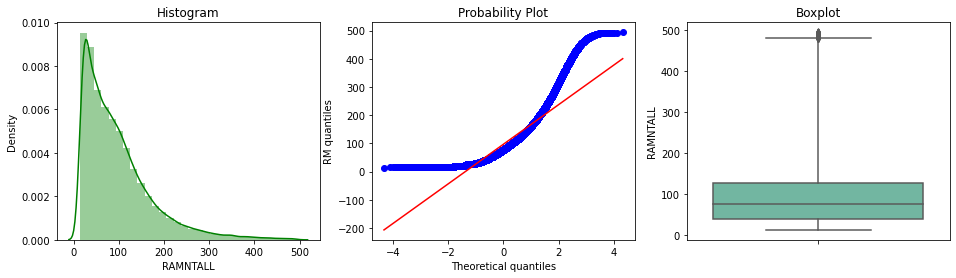

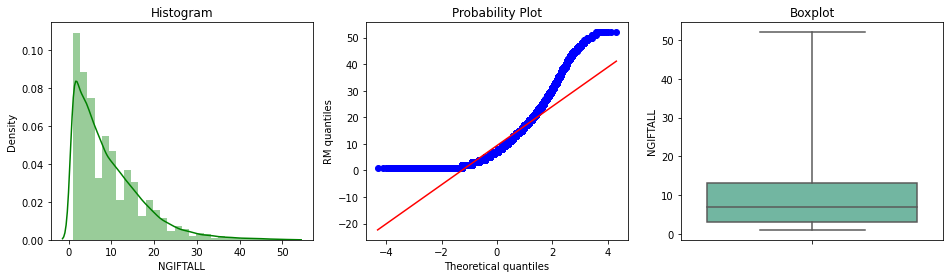

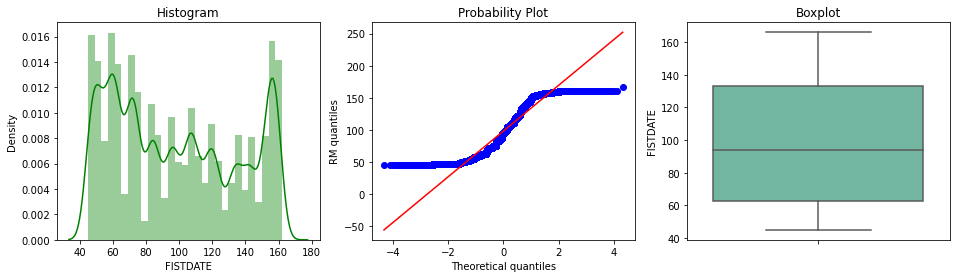

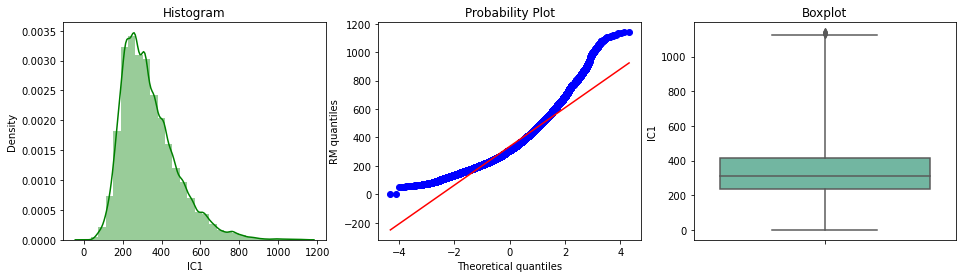

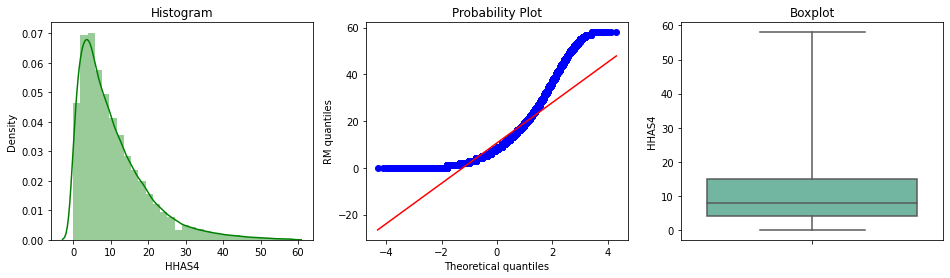

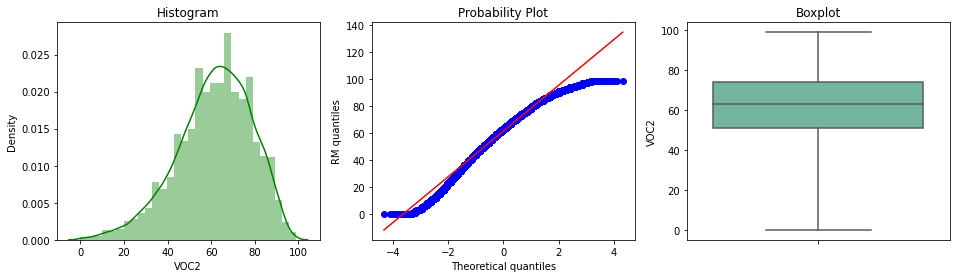

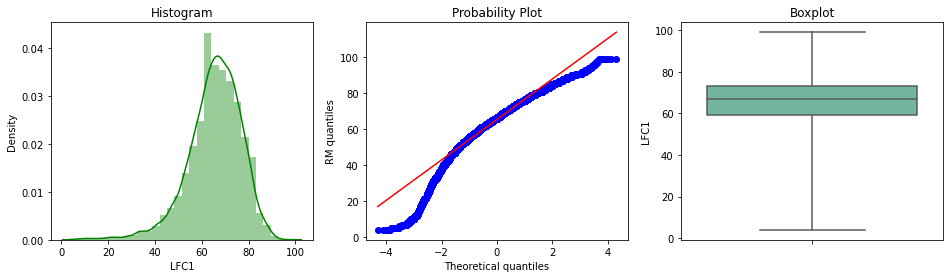

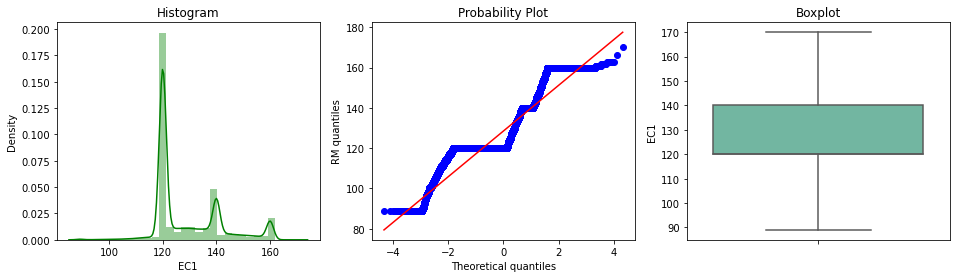

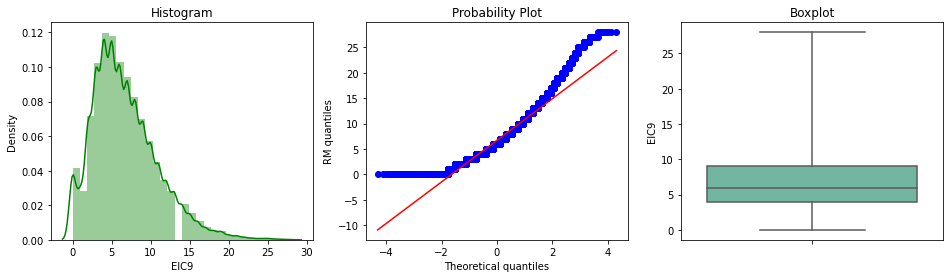

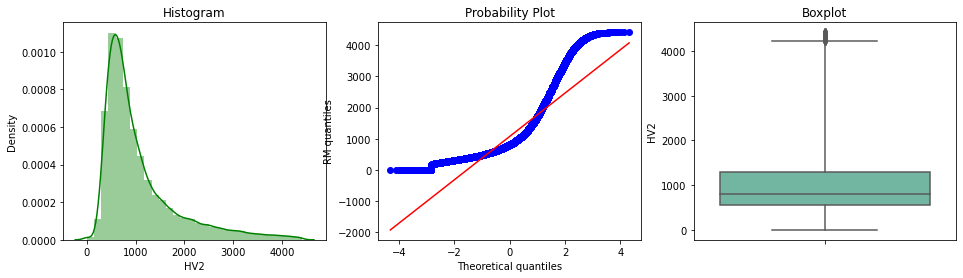

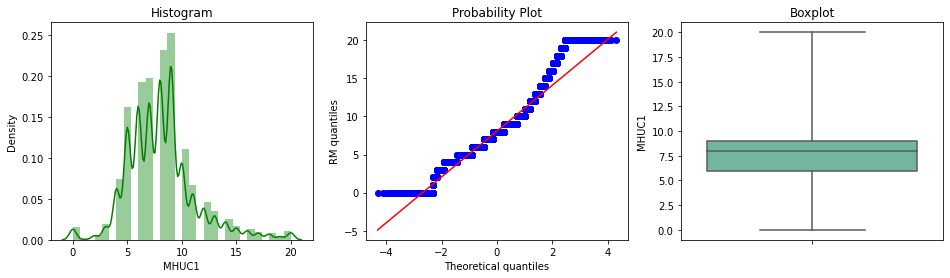

<function __main__.diagnostic_plots(df, variable)>

In [115]:
diagnostic_check(neighb_outliers)

In [116]:
check_gift = neighb_outliers[['RAMNTALL','NGIFTALL','FISTDATE']]

In [117]:
check_neighb = neighb_outliers[['IC1', 'HHAS4', 'VOC2','LFC1', 'EC1', 'EIC9', 'HV2', 'MHUC1']]

In [118]:
# sns.pairplot(check_neighb)

In [125]:
cor_afte = check_gift.corr(method = "pearson") 

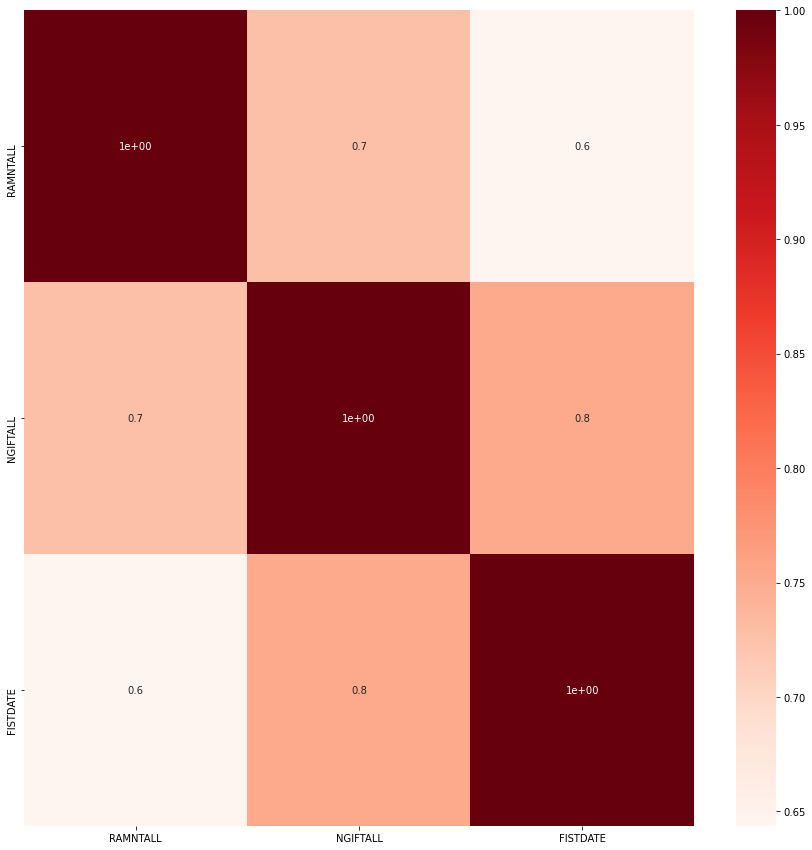

In [126]:
cor_heatmap(cor_afte)

##### SOM for Feature selection

In [121]:
#Neighborhood_cluster

In [122]:
metric_features = neighb_outliers.columns

In [123]:
# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(42)

In [124]:
# Notice that the SOM did not converge - We're under a time constraint for this class
sm = sompy.SOMFactory().build(
    neighb_outliers.values, 
    mapsize=(25, 25), 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=metric_features
)
sm.train(n_job=-1, verbose='info', train_rough_len=100, train_finetune_len=100)

 Training...
 random_initialization took: 0.001000 seconds
 Rough training...
 radius_ini: 9.000000 , radius_final: 1.500000, trainlen: 100

 epoch: 1 ---> elapsed time:  0.261000, quantization error: 3.533446

 epoch: 2 ---> elapsed time:  0.266000, quantization error: 3.076850

 epoch: 3 ---> elapsed time:  0.270000, quantization error: 3.029433

 epoch: 4 ---> elapsed time:  0.276000, quantization error: 3.001124

 epoch: 5 ---> elapsed time:  0.281000, quantization error: 2.986548

 epoch: 6 ---> elapsed time:  0.309000, quantization error: 2.977645

 epoch: 7 ---> elapsed time:  0.268000, quantization error: 2.972714

 epoch: 8 ---> elapsed time:  0.260000, quantization error: 2.969649

 epoch: 9 ---> elapsed time:  0.279000, quantization error: 2.967208

 epoch: 10 ---> elapsed time:  0.316000, quantization error: 2.964908

 epoch: 11 ---> elapsed time:  0.276000, quantization error: 2.962596

 epoch: 12 ---> elapsed time:  0.304000, quantization error: 2.960235

 epoch: 13 ---> 

KeyboardInterrupt: 

In [ ]:
# Coordinates of the units in the input space
sm.get_node_vectors()

# Component planes on the 50x50 grid
sns.set()
view2D = View2D(12,12,"", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.show()

In [ ]:
# neighb_outliers.to_csv('Selected_features-7.6age.csv')